# Optic chiasm mask refinement

This jupyter document presents in the step-by-step fashion the algorithm used for correction of X-mask<sub>atlas-initial</sub> output by FreeSurfer. The output optic chiasm masks, later referred to as X-mask<sub>atlas-correced</sub>, were subsequently used for the purpose of training of Convolutional Neural Network.

The presented code has been copied from `functions.py` file providing all the necessary functions for the main `1_Create_X-mask_atlas-corrected.py` script, which should be run in order to create X-mask<sub>atlas-correced</sub>.

----------------------------
@author 
Robert Puzniak
rjpuzniak@gmail.com
June, 2021

## Import of required libraries and supporting functions

In [1]:
# Import of libraries

import nibabel as nib
import numpy as np
import os

from nilearn.image import resample_img
from skimage.measure import label
from scipy.ndimage.morphology import binary_dilation

In [2]:
# *Exlucsively for explanation*
import matplotlib.pyplot as plt

```bounding_box``` is a helper function which returns coordinates of bounding box containing all non-zero values in given 3D array ```img```. The ```_offset``` variables regulate the margin between input structure and the edge of bounding box. This helper function was used to extract coordinates of subregion of brain containing optic chiasm mask returned by FreeSurfer.

In [3]:
# Function selecting a bounding box (with a margin of choice) around optic chiasm mask created by FreeSurfer

def bounding_box(img, x_offset, y_offset, z_offset):

    a = np.any(img, axis=(1, 2))
    b = np.any(img, axis=(0, 2))
    c = np.any(img, axis=(0, 1))

    amin, amax = np.where(a)[0][[0, -1]]
    bmin, bmax = np.where(b)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]

    return amin-x_offset, amax+x_offset, bmin-y_offset, bmax+y_offset, cmin-z_offset, cmax+z_offset

In [4]:
# Function visualization the process by showing the mask overlaid on T1w images axial slices
def view_compare(img1, img2, start_slice, number_slices, x_s, x_e, y_s, y_e, alone=False, overlaid=False):

    fig = plt.figure(figsize=(50,50))
    
    if alone:
            for i in range(number_slices):
                fig.add_subplot(number_slices/3,3,i+1)
                plt.imshow(img1[x_s:x_e,y_s:y_e,start_slice+i], cmap='gray')
                plt.title(str(i), fontsize=40)
    
    elif overlaid:
            for i in range(number_slices):
                fig.add_subplot(number_slices/3,3,i+1)
                plt.imshow(img1[x_s:x_e,y_s:y_e,start_slice+i], cmap='gray')
                plt.imshow(img2[x_s:x_e,y_s:y_e,start_slice+i]>0.1, cmap='plasma', alpha=0.25)  
                plt.title(str(i), fontsize=40)
    else:
            for i in range(number_slices):
                fig.add_subplot(number_slices,2,2*i+1)
                plt.imshow(img1[x_s:x_e,y_s:y_e,start_slice+i], cmap='gray')
                fig.add_subplot(number_slices,2,2*i+2)
                plt.imshow(img2[x_s:x_e,y_s:y_e,start_slice+i], cmap='gray', alpha=1)
                plt.title(str(i), fontsize=40)

## Mask's refinement code explained

The code accepts as arguments: group the patient belong to (either "HCP" or "CHIASM"), patient's ID (6-digit ID for HCP, for CHIASM participants in either `CON{}` or `ALB{}` for controls and participants with albinism, respecitvely), and margins for bounding box (tuple of 3 defining the number of margin voxels along x-, y- and z-axis).

For the purpose of this presentation, we will use the `100206` participant from `HCP` dataset and the default values for margins of bounding box `(5,5,0)`.

In [5]:
group='HCP'
subj='100206'
box_margin=(5,5,0)

The images of T1w and the X-mask<sub>atlas-initial</sub> (from the `1_Data` folder) are being loaded

In [6]:
# Define paths to images and load images
t1w_path='../../1_Data/1_T1w_Images/'+group+'/'+str(subj)+'/t1.nii.gz'
ocmask_path='../../1_Data/3_X-mask_atlas-initial/'+group+'/'+str(subj)+'/X-mask_atlas-initial_complete.nii.gz'
    
# Load images
t1w_file, ocmask_file = nib.load(t1w_path), nib.load(ocmask_path)

In order to account for various voxel sizes, the optic chiasm mask is resampled to T1w image's resolution. Afterwards the data (stored as matrices) are being directly extracted from the files.

In [7]:
# Resample mask image to the T1w
ocmask_resampled_file = resample_img(ocmask_file, t1w_file.affine, t1w_file.shape, 'linear')
    
# Extract data
t1w_data = t1w_file.get_fdata()
ocmask_resampled_data = ocmask_resampled_file.get_fdata()

We save the coordinates spanning the bounding box around the optic chiasm (with a chosen margin)

In [8]:
# *Just for explanation* Calculate bounding box of the optic chiasm
a_min, a_max, b_min, b_max, c_min, c_max = bounding_box(ocmask_resampled_data,*box_margin)

Exclusively for purpose of this segmentation a copy of X-mask<sub>atlas-initial</sub> is created here. This mask will be compared in the end with the X-mask<sub>atlas-corrected</sub> mask.

In [9]:
# *Just for explanation* Create the copy of X-mask_atlas-initial - it will be compared at the end with the outcome of mask refinement
old_ocmask_resampled_data = ocmask_resampled_data.copy()

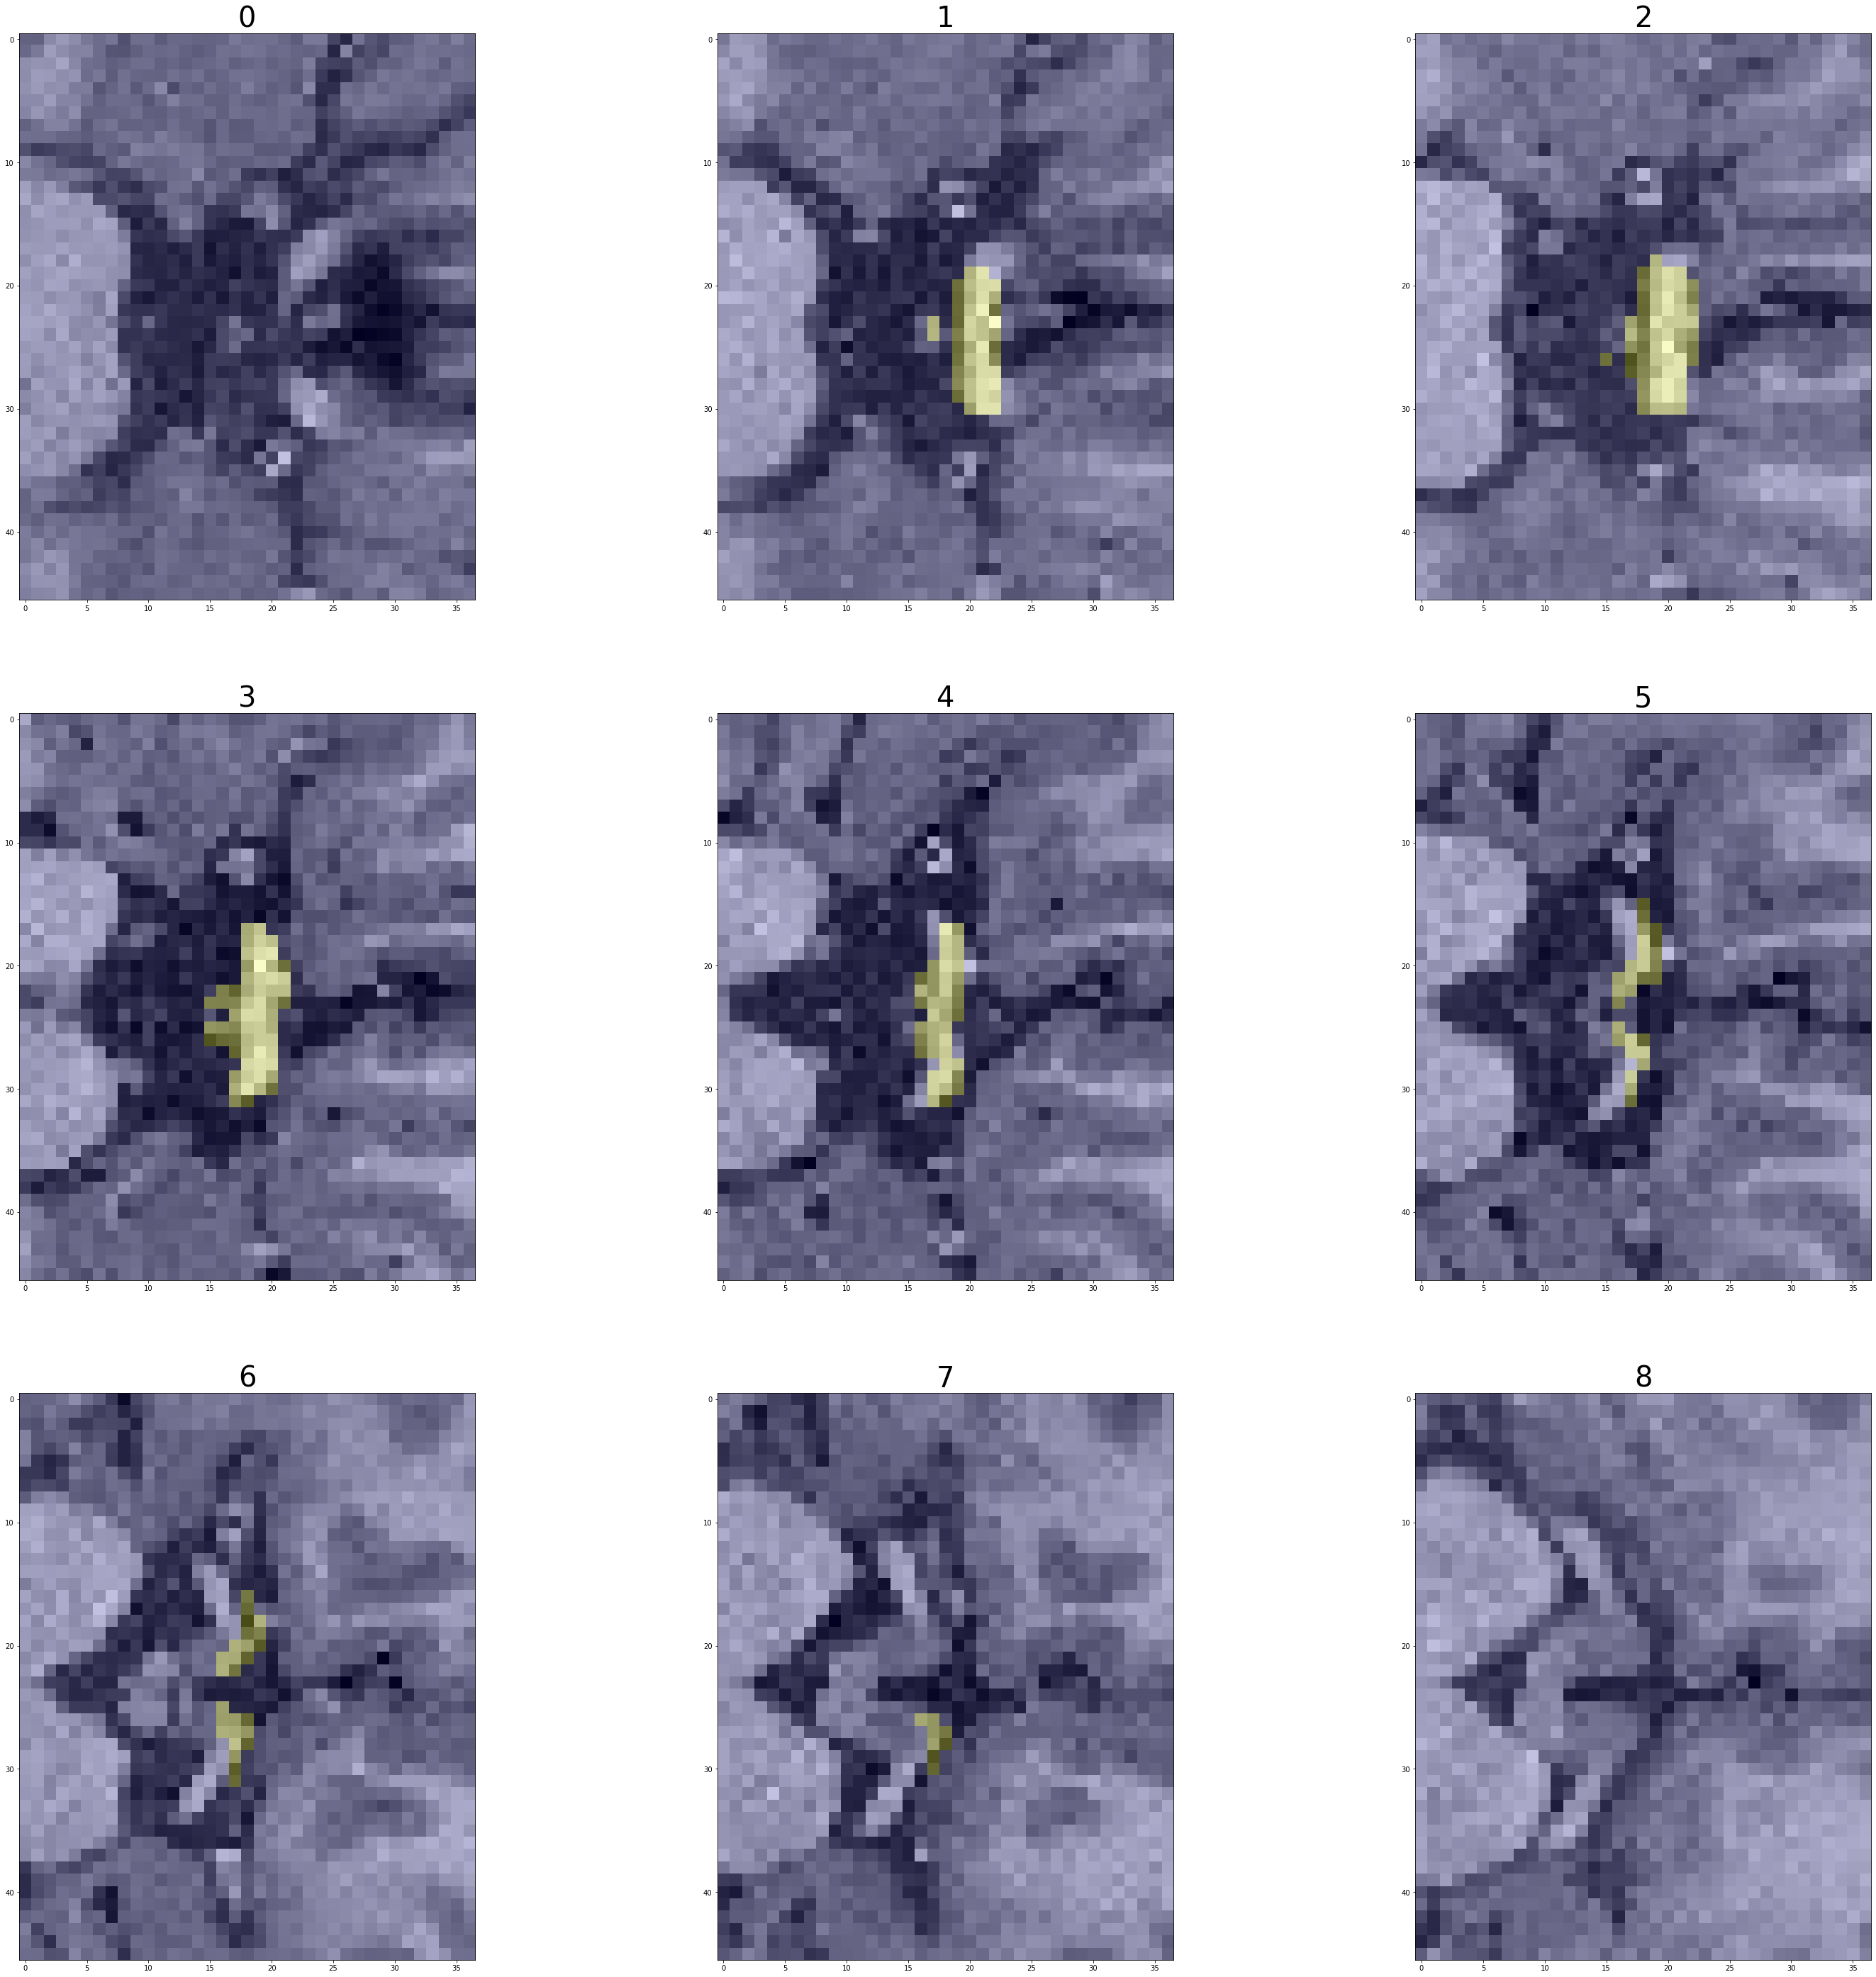

In [10]:
# *Just for explanation* Display the cropped T1-weighted image with overlaid X-mask_atlas-initial
view_compare(t1w_data,ocmask_resampled_data,c_min-1,9, *(a_min-10,a_max+10,b_min-10,b_max+10),False, True)

The overlaid X-mask<sub>atlas-initial</sub> is clearly inaccurate, as it misses voxels belonging to optic chiasm (e.g. **image 1**) and expands into tissue surrounding the optic chiasm (e.g. hypothalamus, as visible on **image 3**), yet most of it voxels corresponds to optic chiasm voxels. In order to leverage the fact, that X-mask<sub>atlas-initial</sub> provides information about true positive optic chiasm voxels, as well as false negatives, the intensities of voxels within the mask will guide the refining process. Speficially, the distribution of voxel intensities within X-mask<sub>atlas-initial</sub> is extracted and used in defining thresholds distinguishing chiasm from hyperintense voxels belonging to blood vessles and low intensity voxels of surrounding tissue.

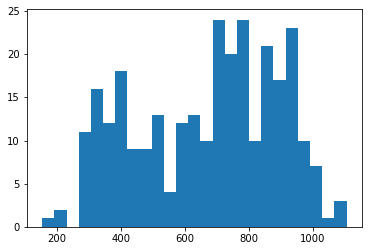

In [11]:
# Intensities of voxels within X-mask_atlas-initial
plt.hist((t1w_data)[np.nonzero(ocmask_resampled_data)].flatten(), bins=25);

The peak corresponds to actual white matter voxels, not affected by partial volume effects. The highest values captured by histogram belong to hyperintense voxels corresponding to blood vessels. In subsequent steps we remove top 2% voxels (in order to remove blood vessels voxels; the choice was based on empirical evidence) and bottom 66% voxels (conservative threshold removing all white matter voxels affected by partial volume and but including all voxels within the core of optic chiasm).

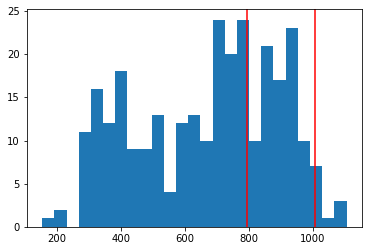

In [12]:
# Find value of 66th percentile of voxel intensity within X-mask_atlas-initial (bottom cutoff threshold for non-white matter voxels)
med_in_chiasm = np.percentile((t1w_data)[np.nonzero(ocmask_resampled_data)],66)
    
# Find 98th percentile (top cutoff for hypterintense blood vessels)
top_in_chiasm = np.percentile((t1w_data)[np.nonzero(ocmask_resampled_data)],98)

# Intensities of voxels within the X-mask_atlas-initial with marked 66th and 98th percentiles
plt.hist((t1w_data)[np.nonzero(ocmask_resampled_data)].flatten(), bins=25);
plt.axvline(x=med_in_chiasm, color='red');
plt.axvline(x=top_in_chiasm, color='red');

As indicated above, the next step is to threshold the voxels from the whole T1-weighted image, so that only those with values between two above-defined threshold are kept.
Below is the effect of removing voxels that are too bright, with overlaid FreeSurfer's optic chiasm mask (yellow):

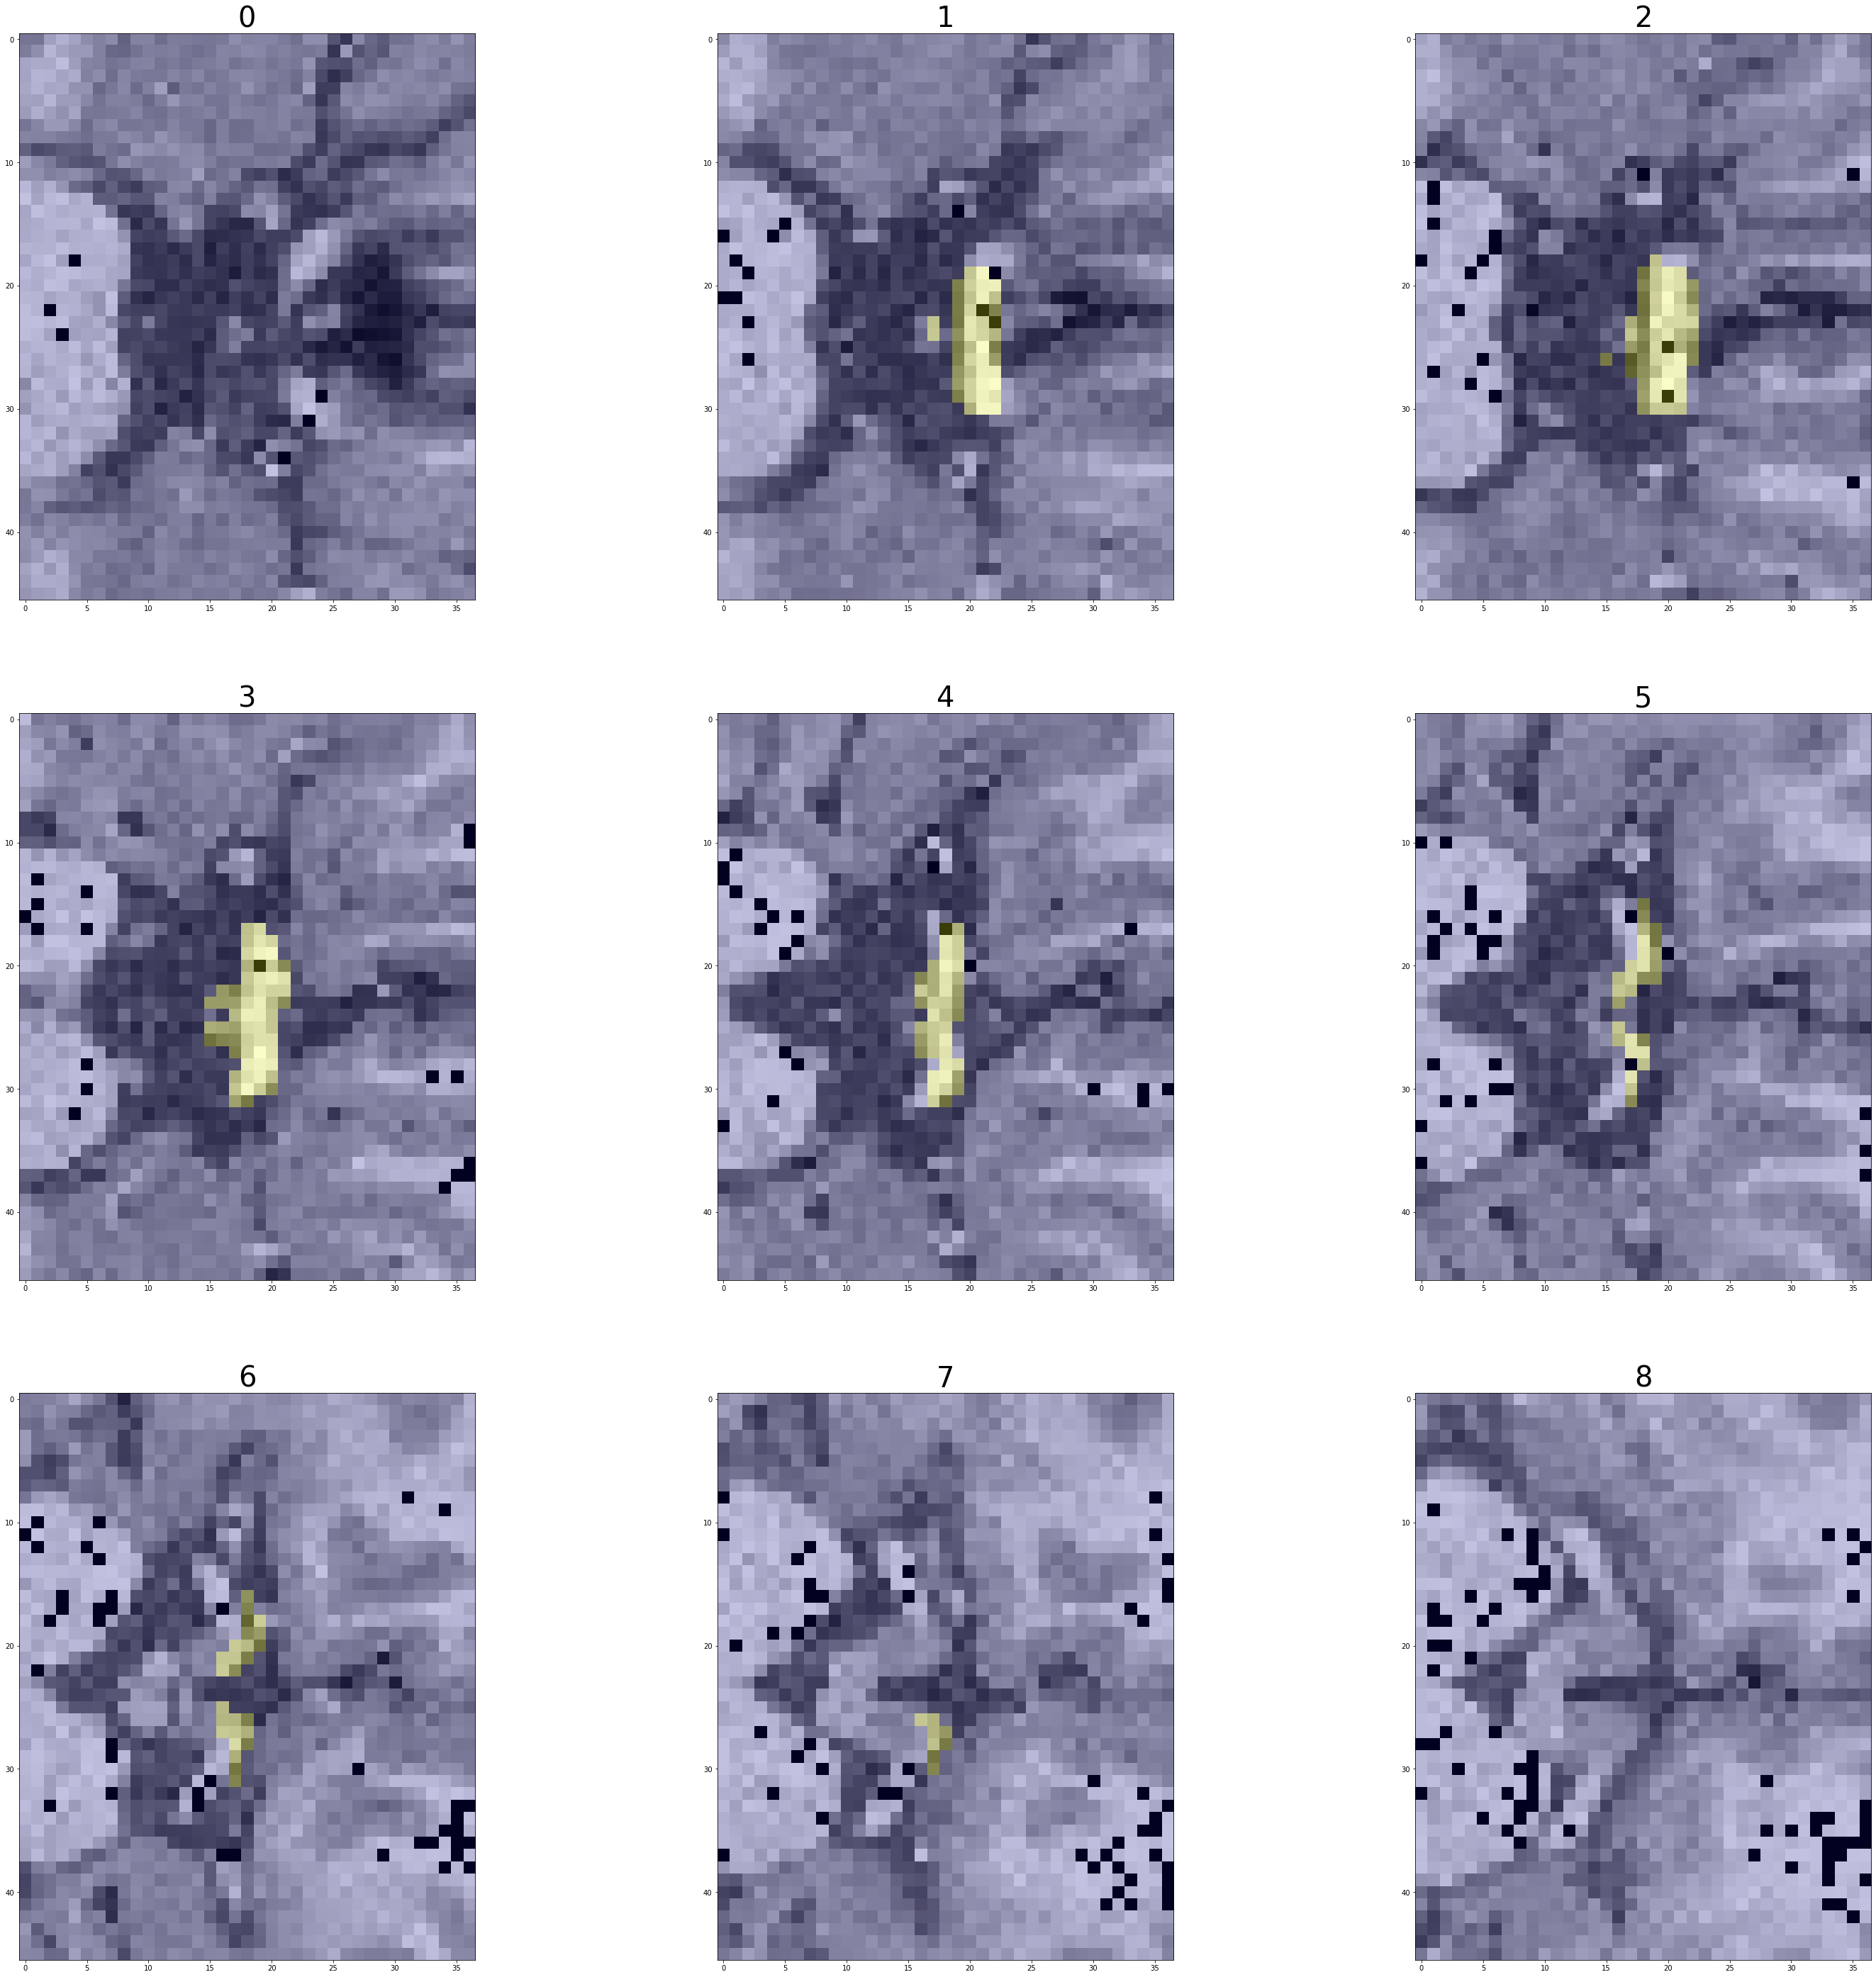

In [13]:
# Keep only voxels below 98th intensity percentile threshold 
t1w_thresh_tmp = (t1w_data< top_in_chiasm)*t1w_data

# View
view_compare(t1w_thresh_tmp,ocmask_resampled_data,c_min-1,9, *(a_min-10,a_max+10,b_min-10,b_max+10),False, True)

In the second step, we will remove voxels that are too dark, so that only well-defined white matter voxels will remain:

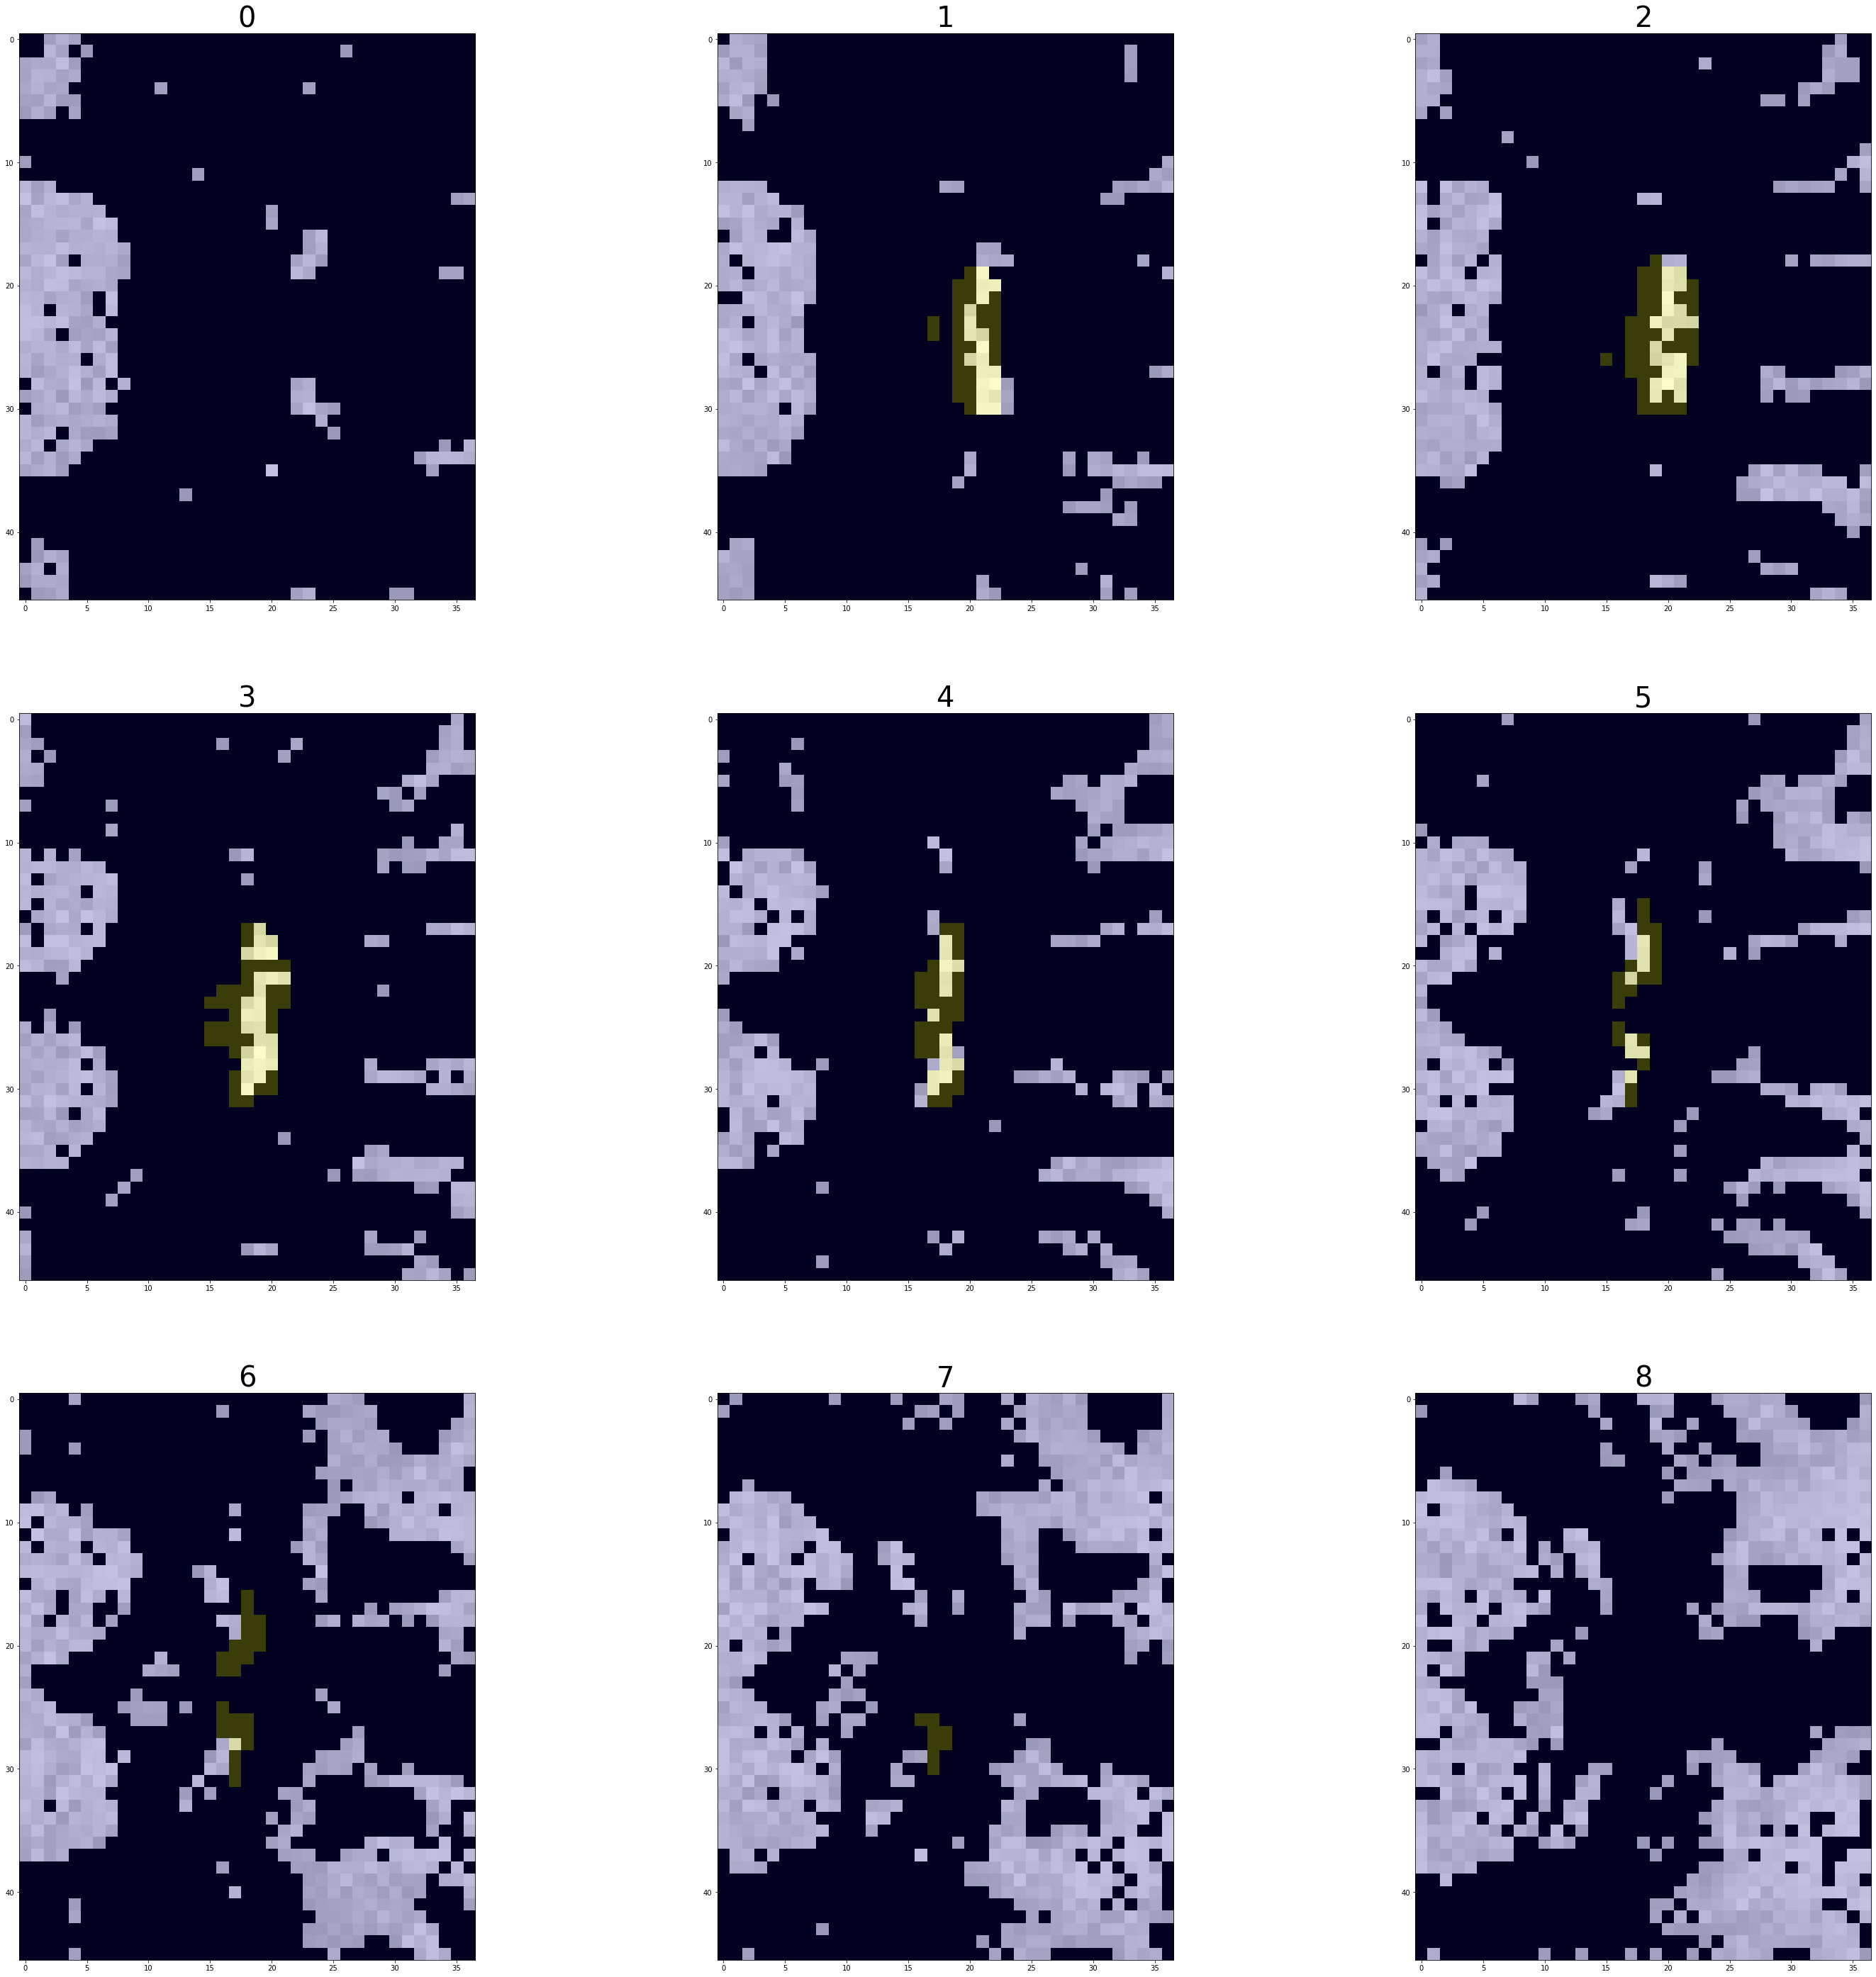

In [14]:
# Keep only voxels above 66th and below 98th intensity percentile threshold
t1w_thresh = (t1w_thresh_tmp> med_in_chiasm)*t1w_thresh_tmp

# View
view_compare(t1w_thresh,ocmask_resampled_data,c_min-1,9, *(a_min-10,a_max+10,b_min-10,b_max+10),False, True)

While several of the remaining voxels belong to the optic chiasm, most of the voxels actually correspond to other structures. In order to extract only the voxels of interest, we once more take an advantage of inital guess provided by X-mask<sub>atlas-initial</sub>. The procedure is as follows:

- the T1-weighted image, which was so far kept in its original (whole brain volume) shape is cropped using the previously calculated bounding box. The bounding box is defined by a dimensions of initial X-mask<sub>atlas-initial</sub> and user defined margin between the mask and bounding box edges - in this case it's margin of 5 voxels in axial space (both in anterior-posterior and left-right directions) and 0 voxels margin along inferior-superior axis.

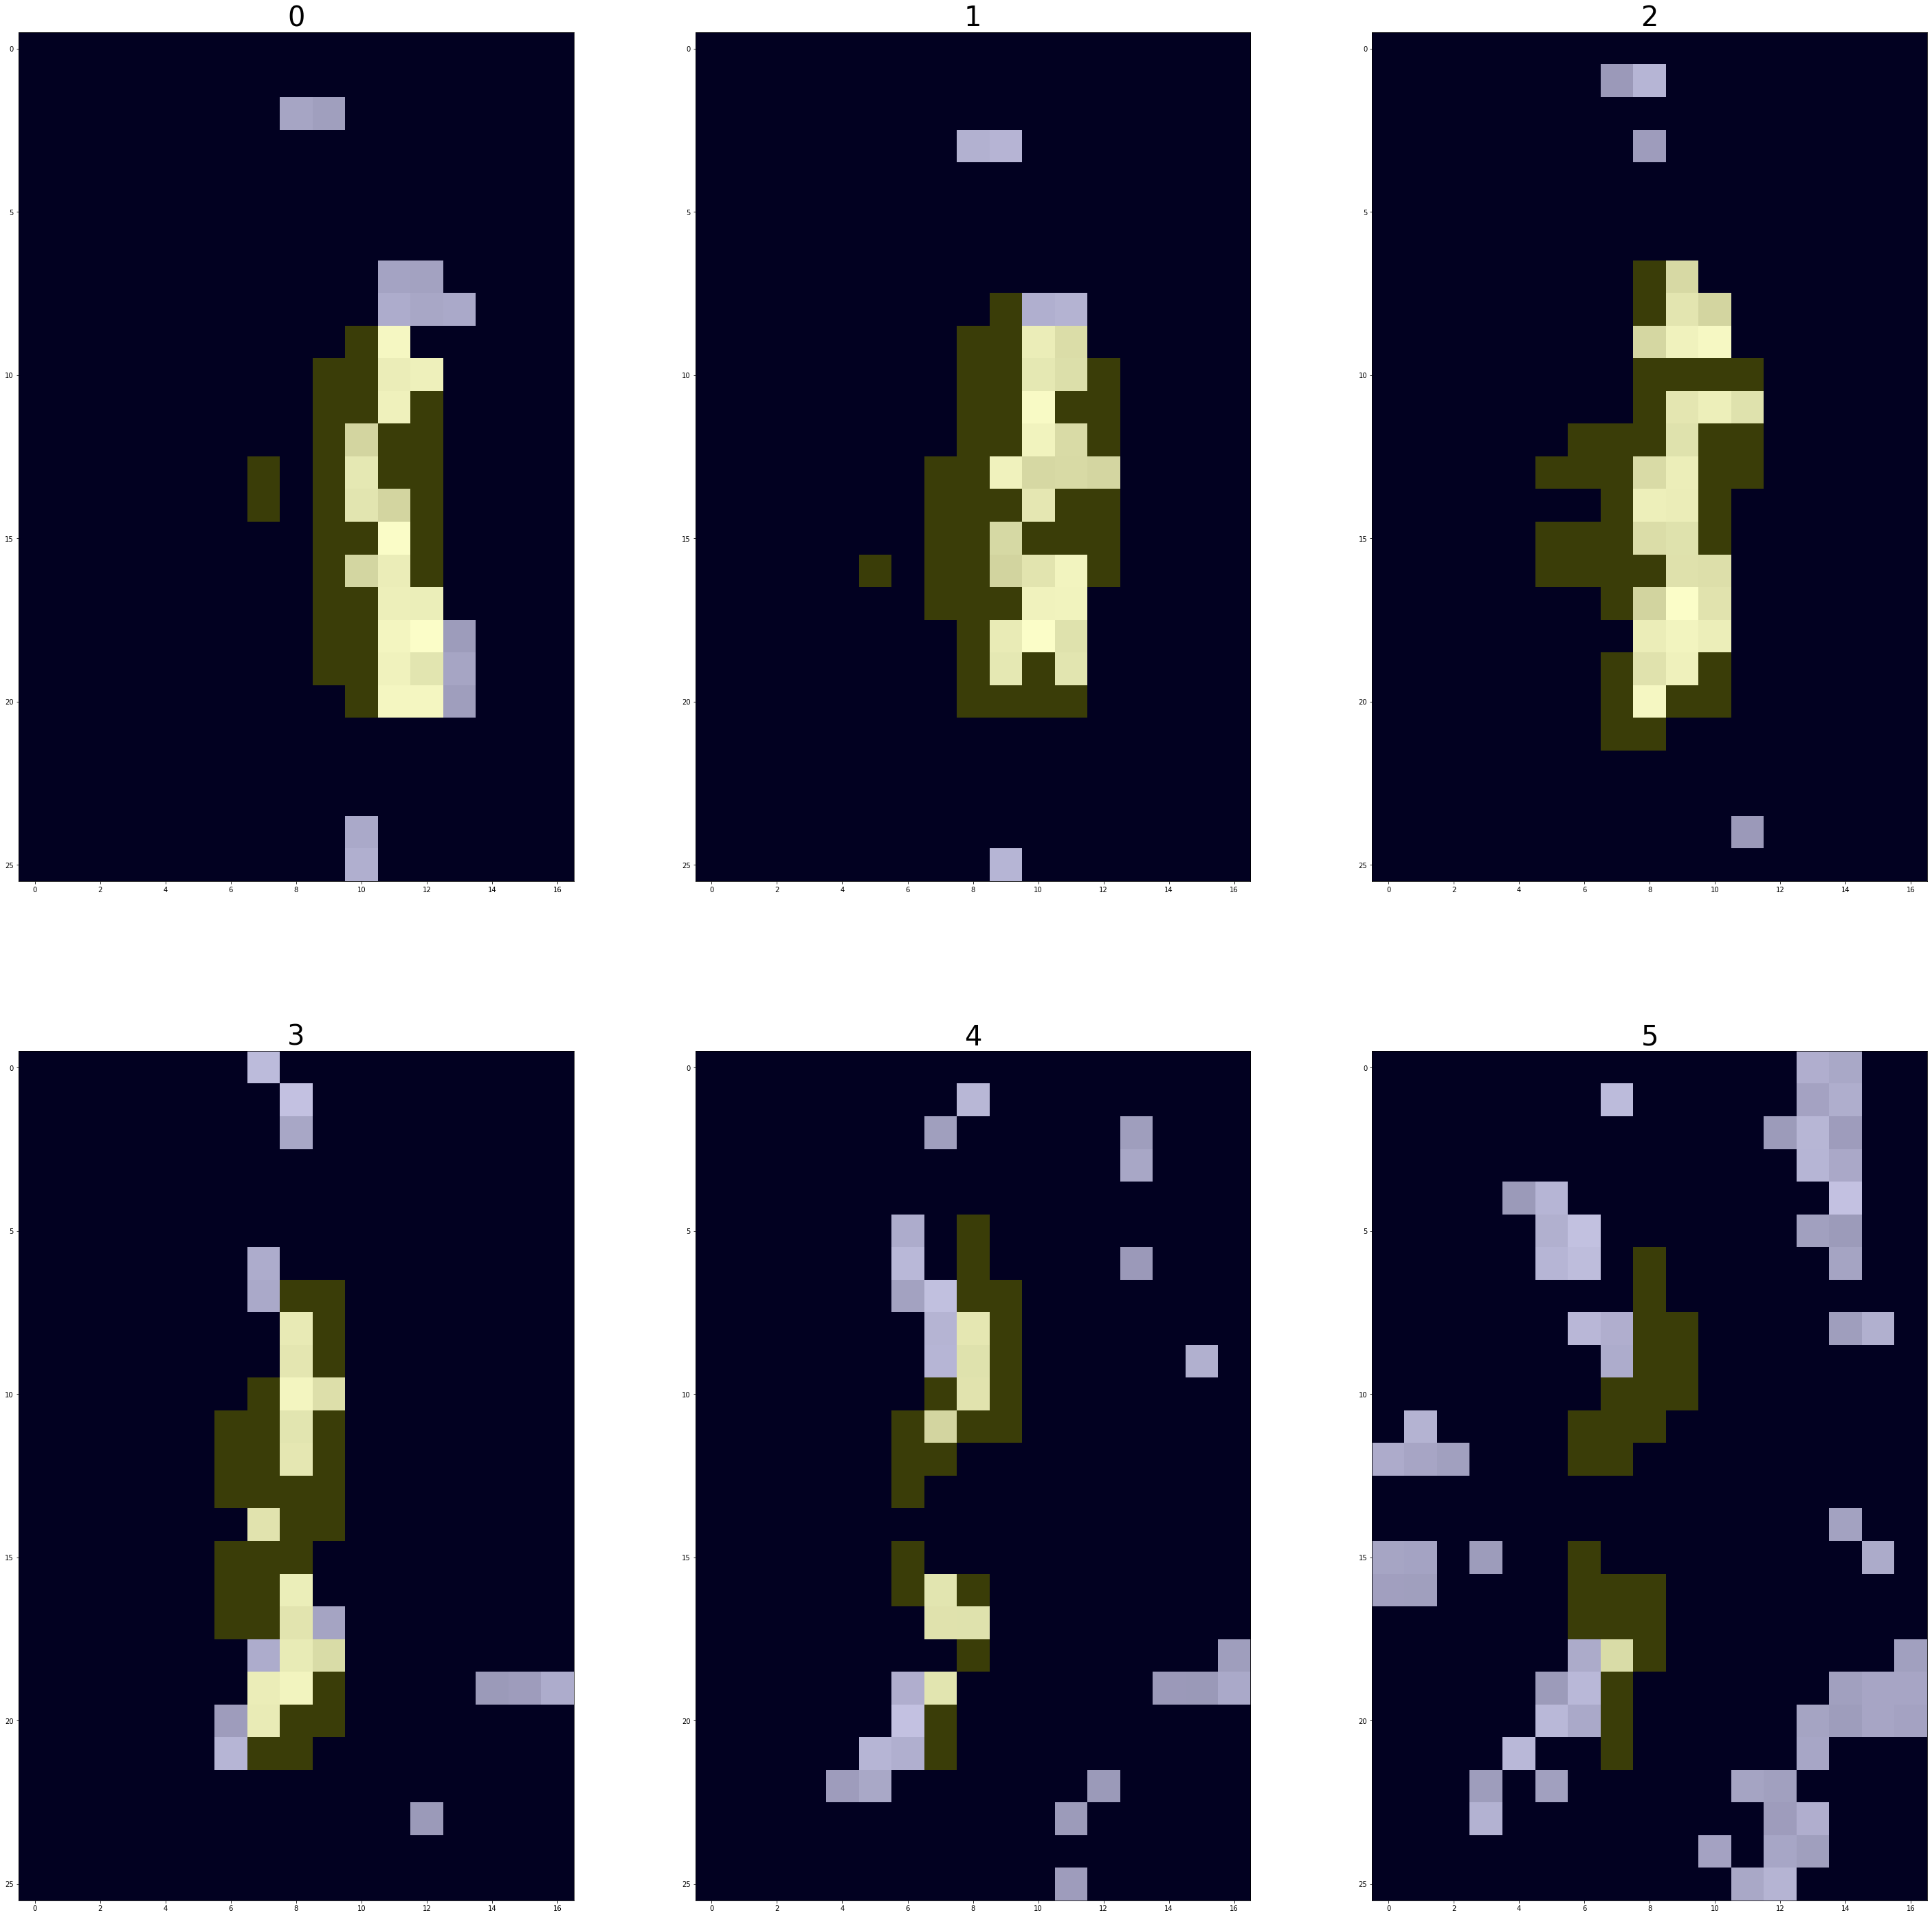

In [15]:
# Crop the original T1-weighted image, thresholded T1-weighted image and X-mask_atlas-initial
# to previously defined bounding box
t1w_box = t1w_thresh[a_min:a_max,b_min:b_max,c_min:c_max]    
oc_box = ocmask_resampled_data[a_min:a_max,b_min:b_max,c_min:c_max]
    
t1w_box_original = t1w_data[a_min:a_max,b_min:b_max,c_min:c_max] 

try:
    view_compare(t1w_box,oc_box,0,t1w_box.shape[2]+2, *(0,t1w_box.shape[0],0,t1w_box.shape[1]),False, True)
except:
    pass

The majority of non-zero voxels belong now to the optic chiasm, but there are still random voxels belonging to other structures. In order to separate voxels forming optic chiasm, we take advantage of the fact that they are closely located and form a cluster. Therefore, the next step is to divide the whole image into clusters and extract the 2nd biggest (since background will be the biggest).

In [16]:
    # Extract 2nd biggest cluster from the bounded box (the biggest one is background)
    clusters = label(np.where(t1w_box!=0,1,0), connectivity=1)
    clusters_sizes = [np.sum(clusters == i) for i in list(np.unique(clusters))]
    
    ordered_sizes = clusters_sizes.copy()
    ordered_sizes.sort()
    
    target_cluster = clusters_sizes.index(ordered_sizes[-2])

Below we demonstrate a cluster created by the above described procedure, which, as expected, corresponds to the actual optic chiasm.

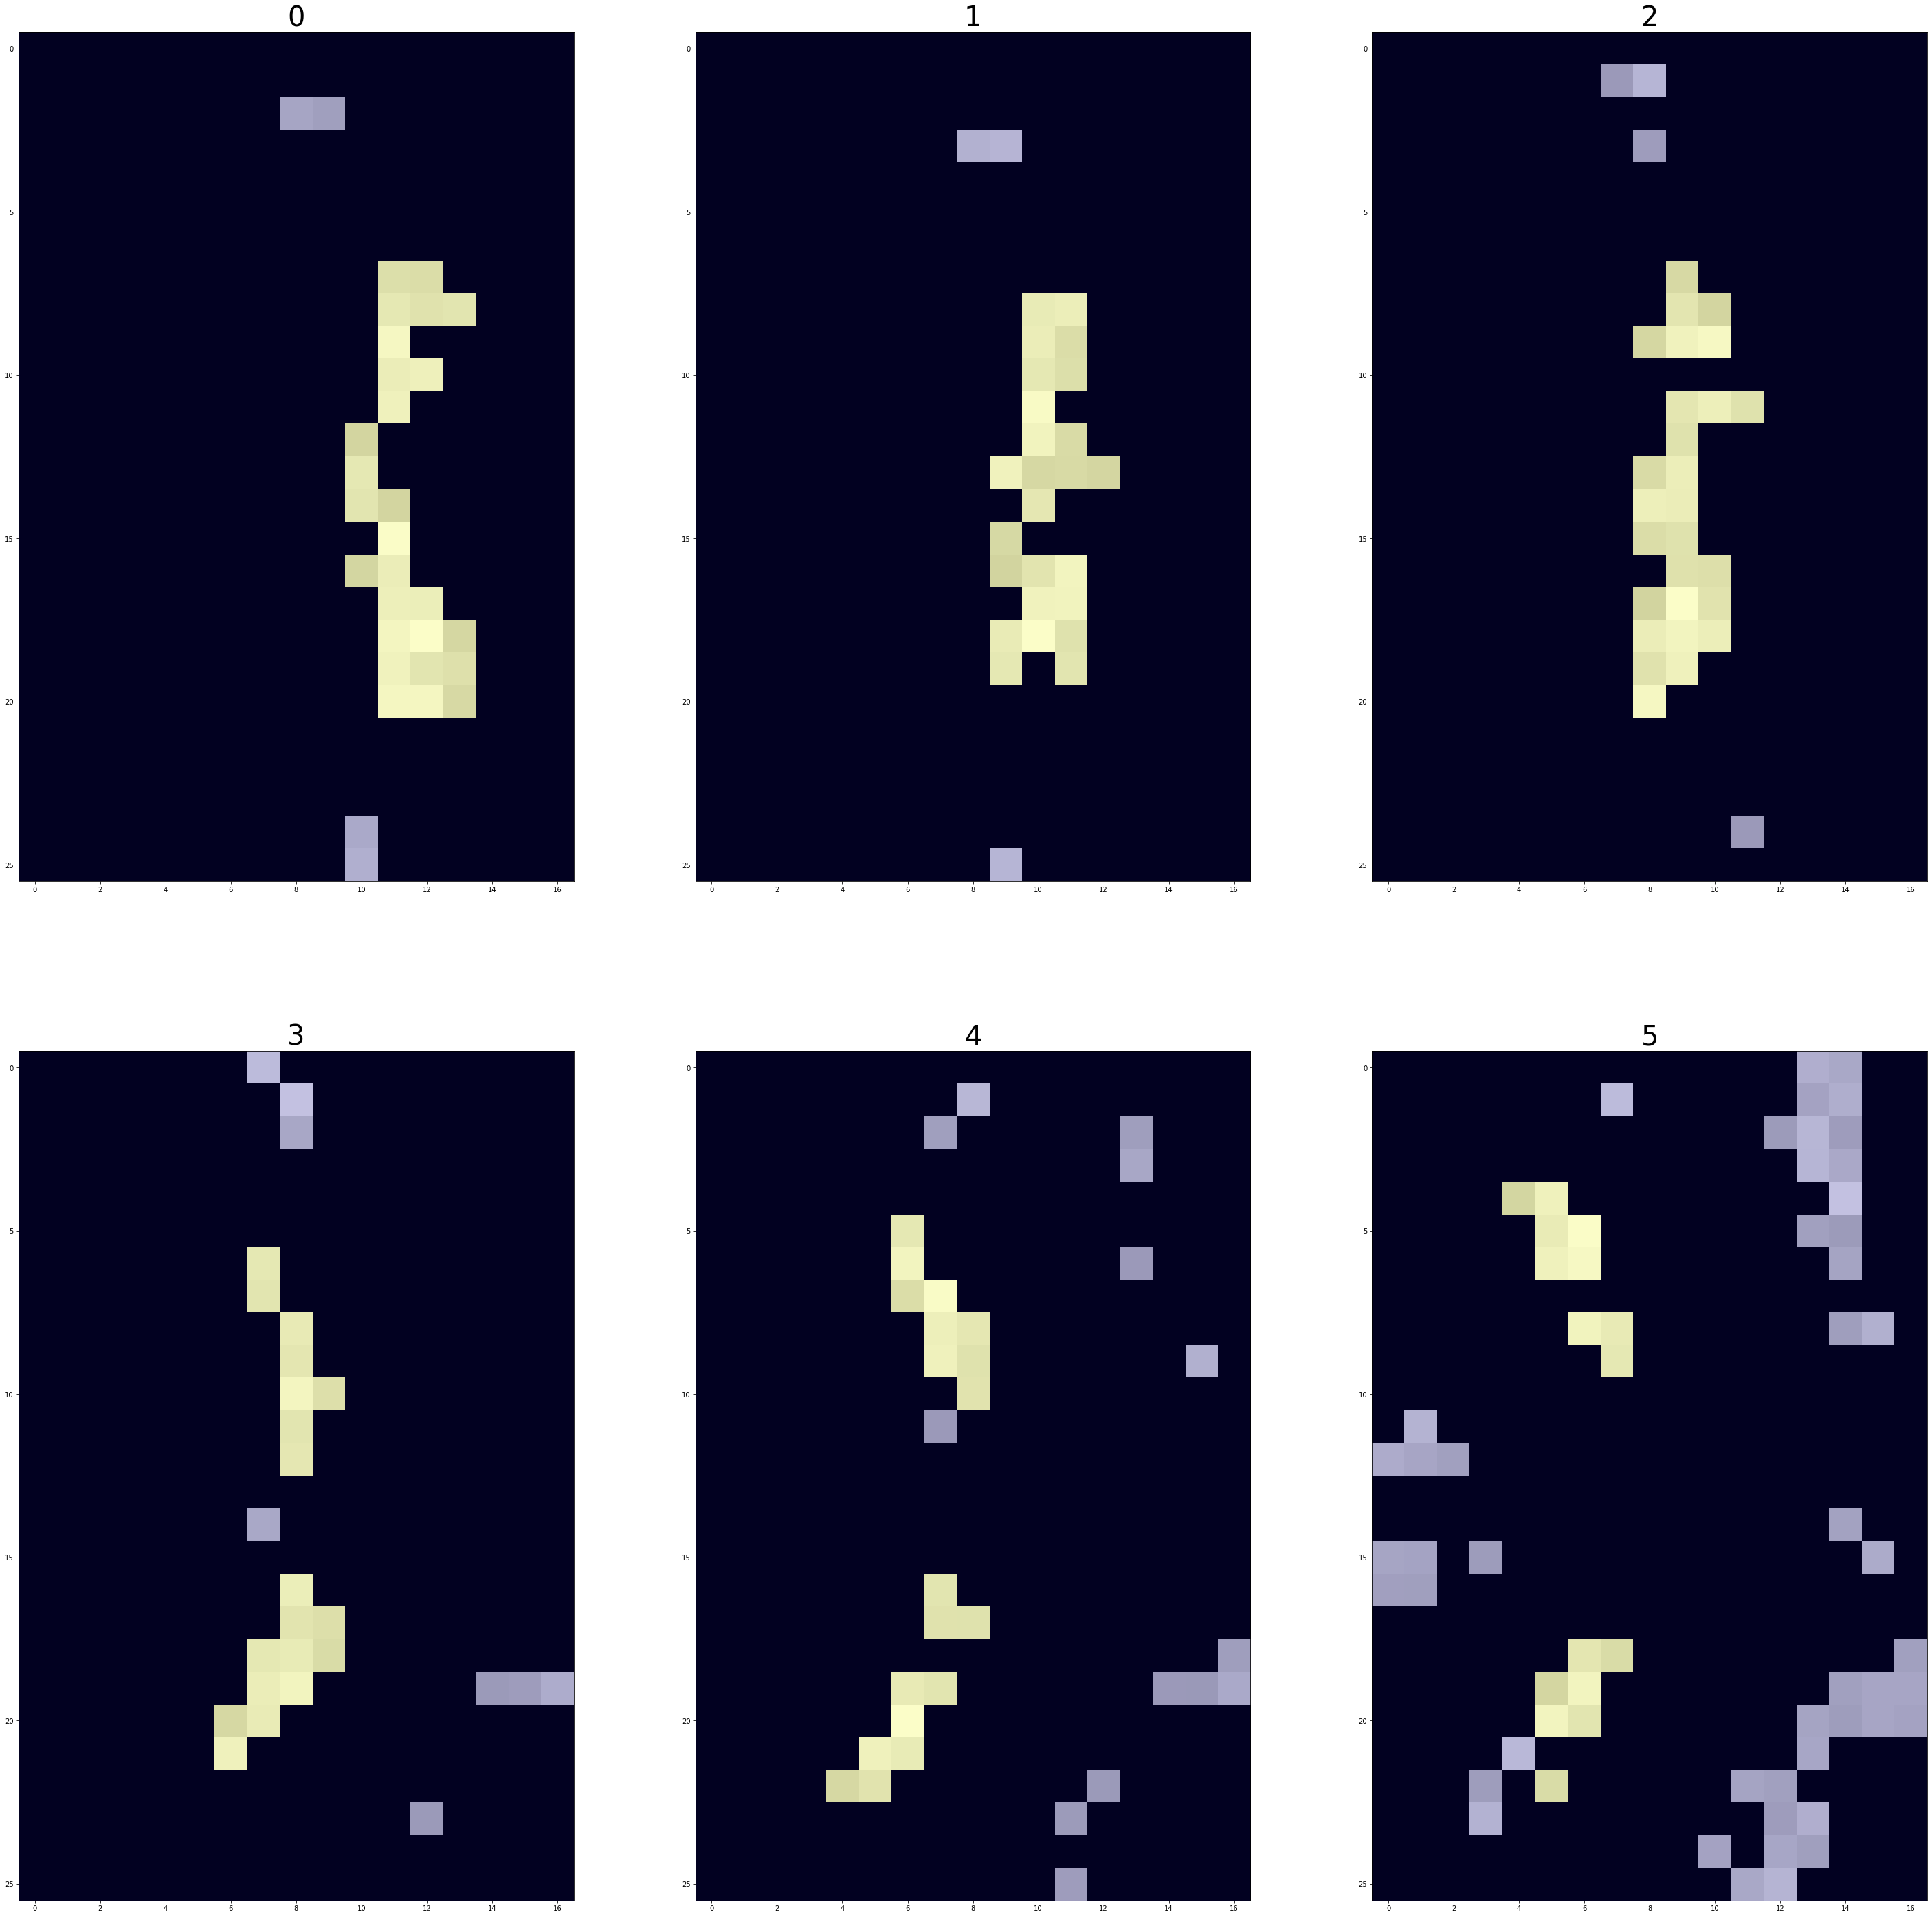

In [17]:
try:
    view_compare(t1w_box,clusters==target_cluster,0,t1w_box.shape[2]+2, *(0,t1w_box.shape[0],0,t1w_box.shape[1]),False, True)
except:
    pass

The last step is to mittigate the effects of very agressive thresholding (using 66th intensity percentile), that removed also voxels that belong to the chiasm, but are affected by partial volume effects. Since the voxels separated by exactly one voxel from surrounding tissue were unaffected by partial volume effects, the solution is to simply dilate already obtained mask by 1 voxel.

In [18]:
    final_cluster = (clusters==target_cluster).astype(int)
    for slice in range(final_cluster.shape[2]):
        final_cluster[:,:,slice] = binary_dilation(final_cluster[:,:,slice])

Below we present the final X-mask<sub>atlas-corrected</sub> overlaid on top of T1-weighted image:

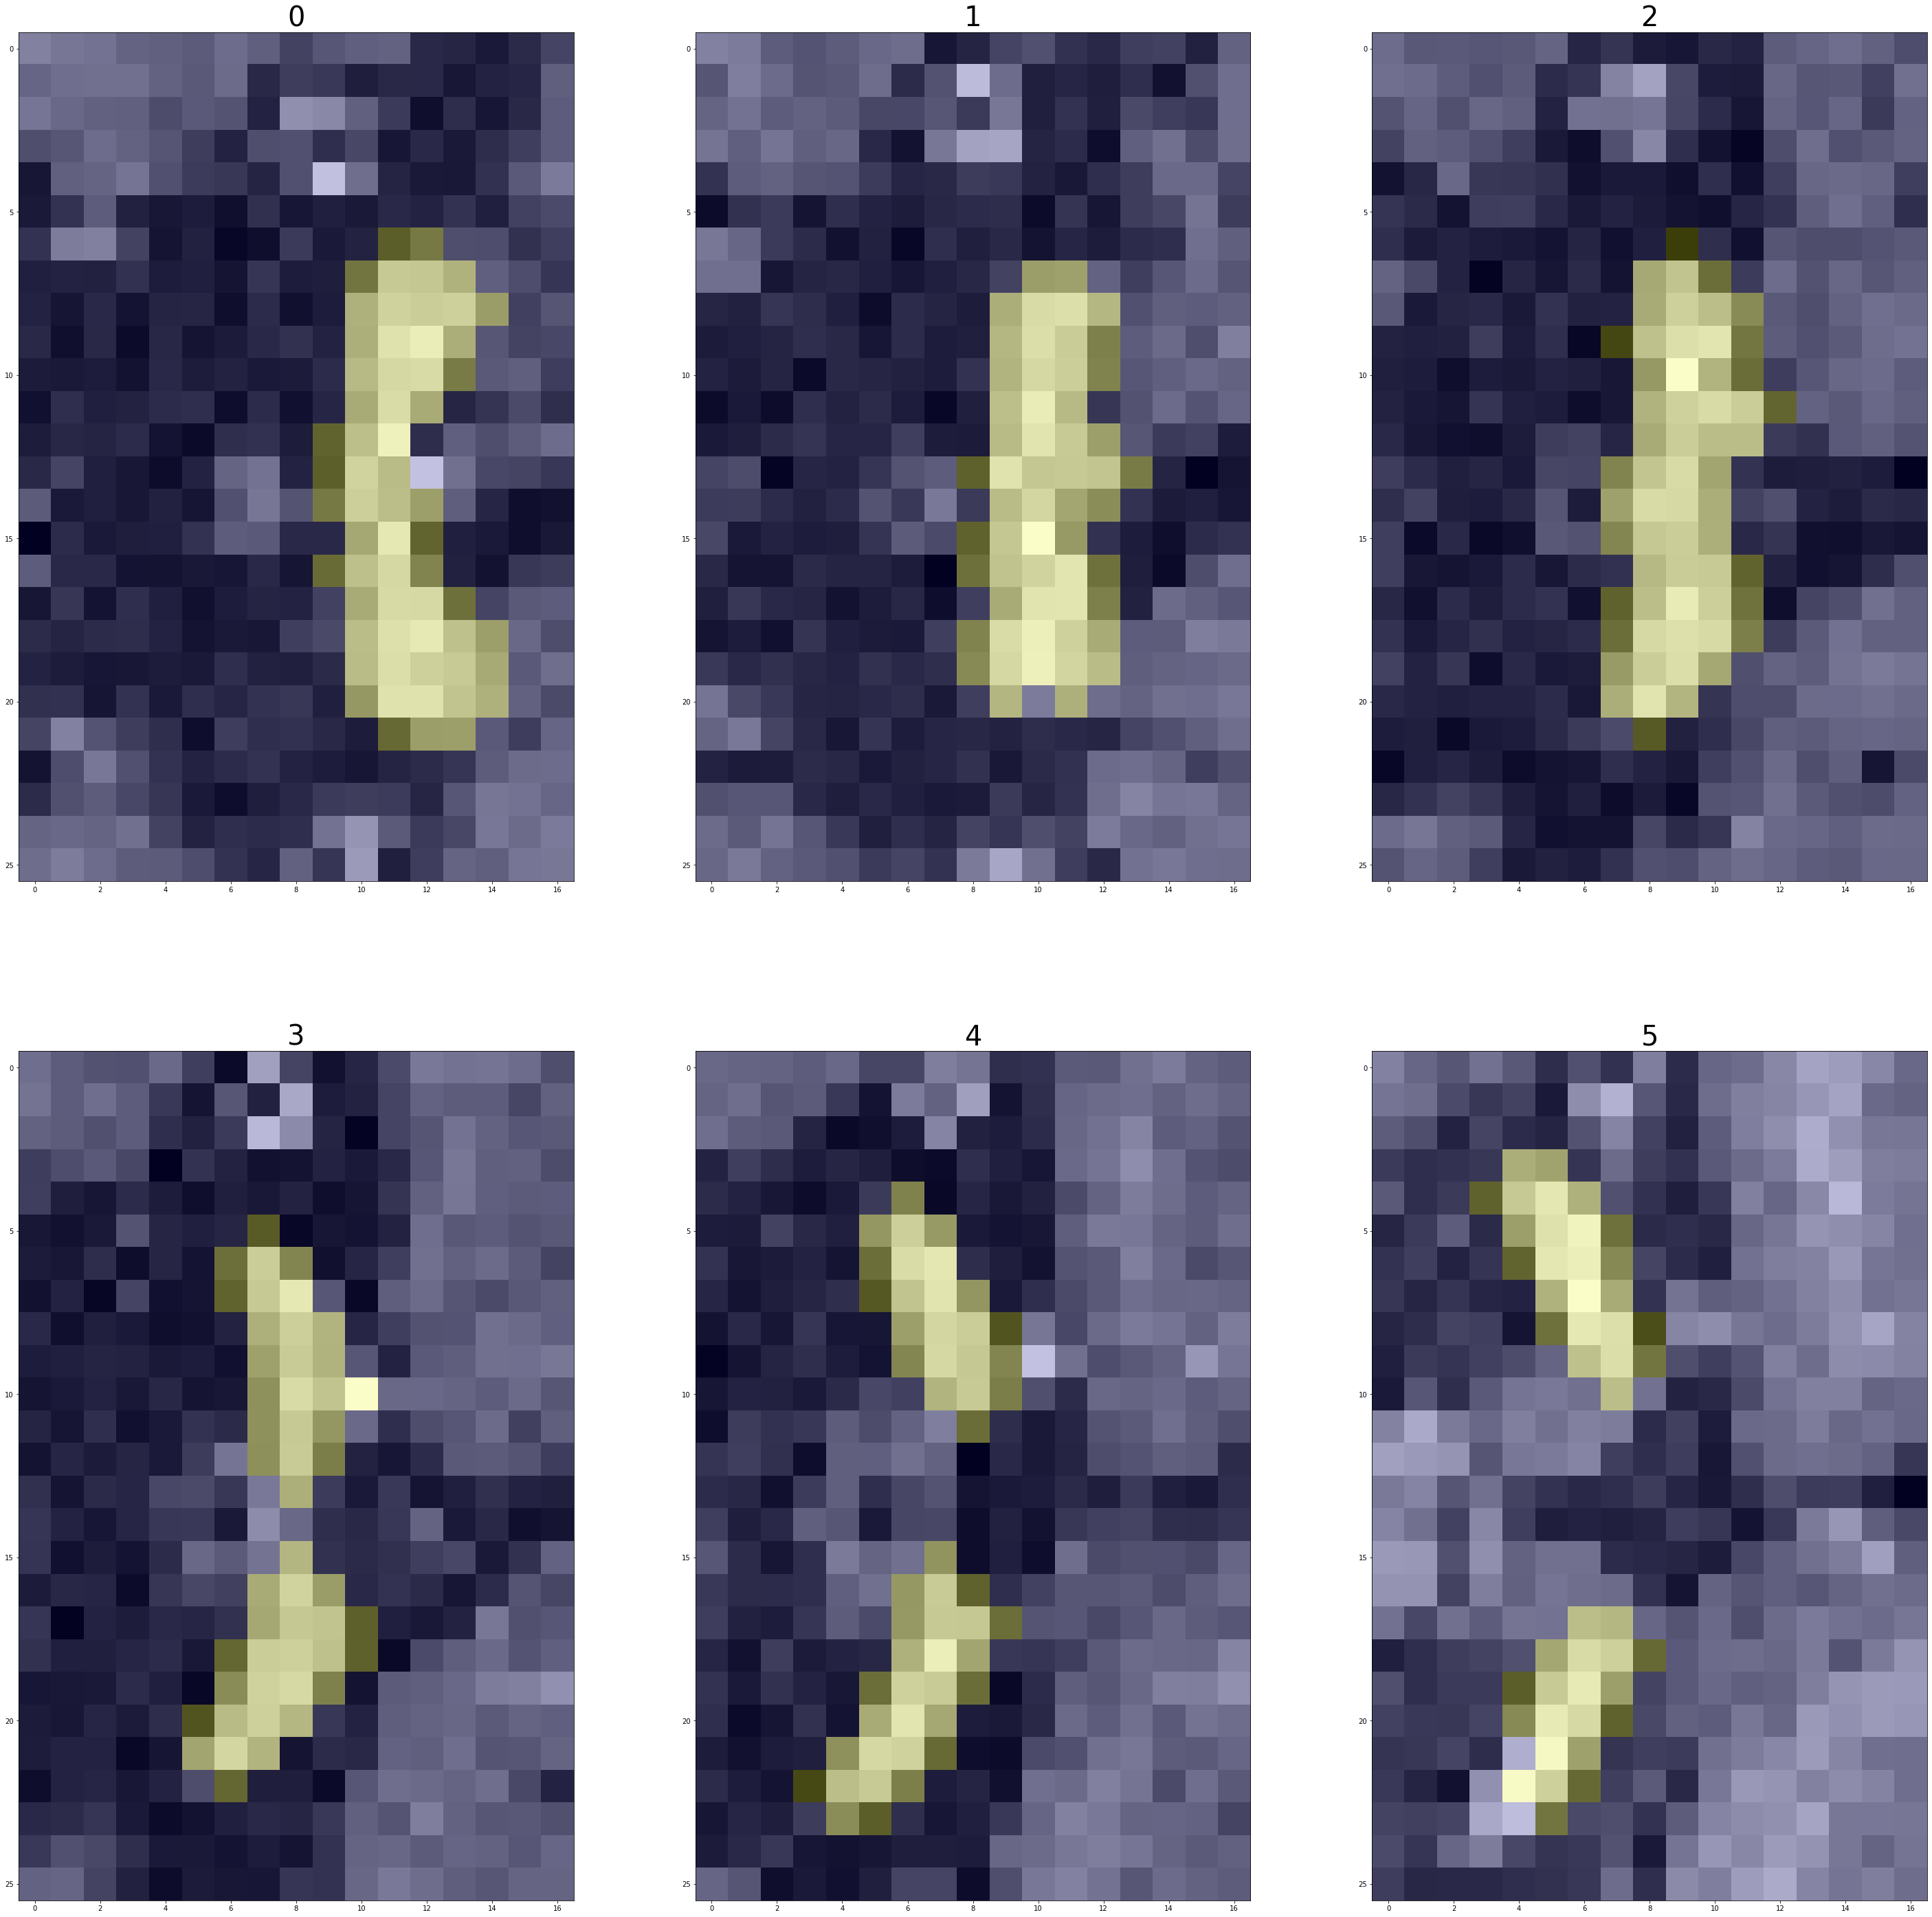

In [19]:
try:
    view_compare(t1w_box_original,final_cluster,0,t1w_box.shape[2]+2, *(0,t1w_box.shape[0],0,t1w_box.shape[1]),False, True)
except:
    pass

In [20]:
# Modify the OC mask image using calculated optimal mask
ocmask_resampled_data[a_min:a_max,b_min:b_max,c_min:c_max] = final_cluster

The last section of script saves the X-mask<sub>atlas-corrected</sub> as a new image to respective location. Here, for the purpose of presentation the display the figure comparing the X-mask<sub>atlas-initial</sub> and X-mask<sub>atlas-corrected</sub>.

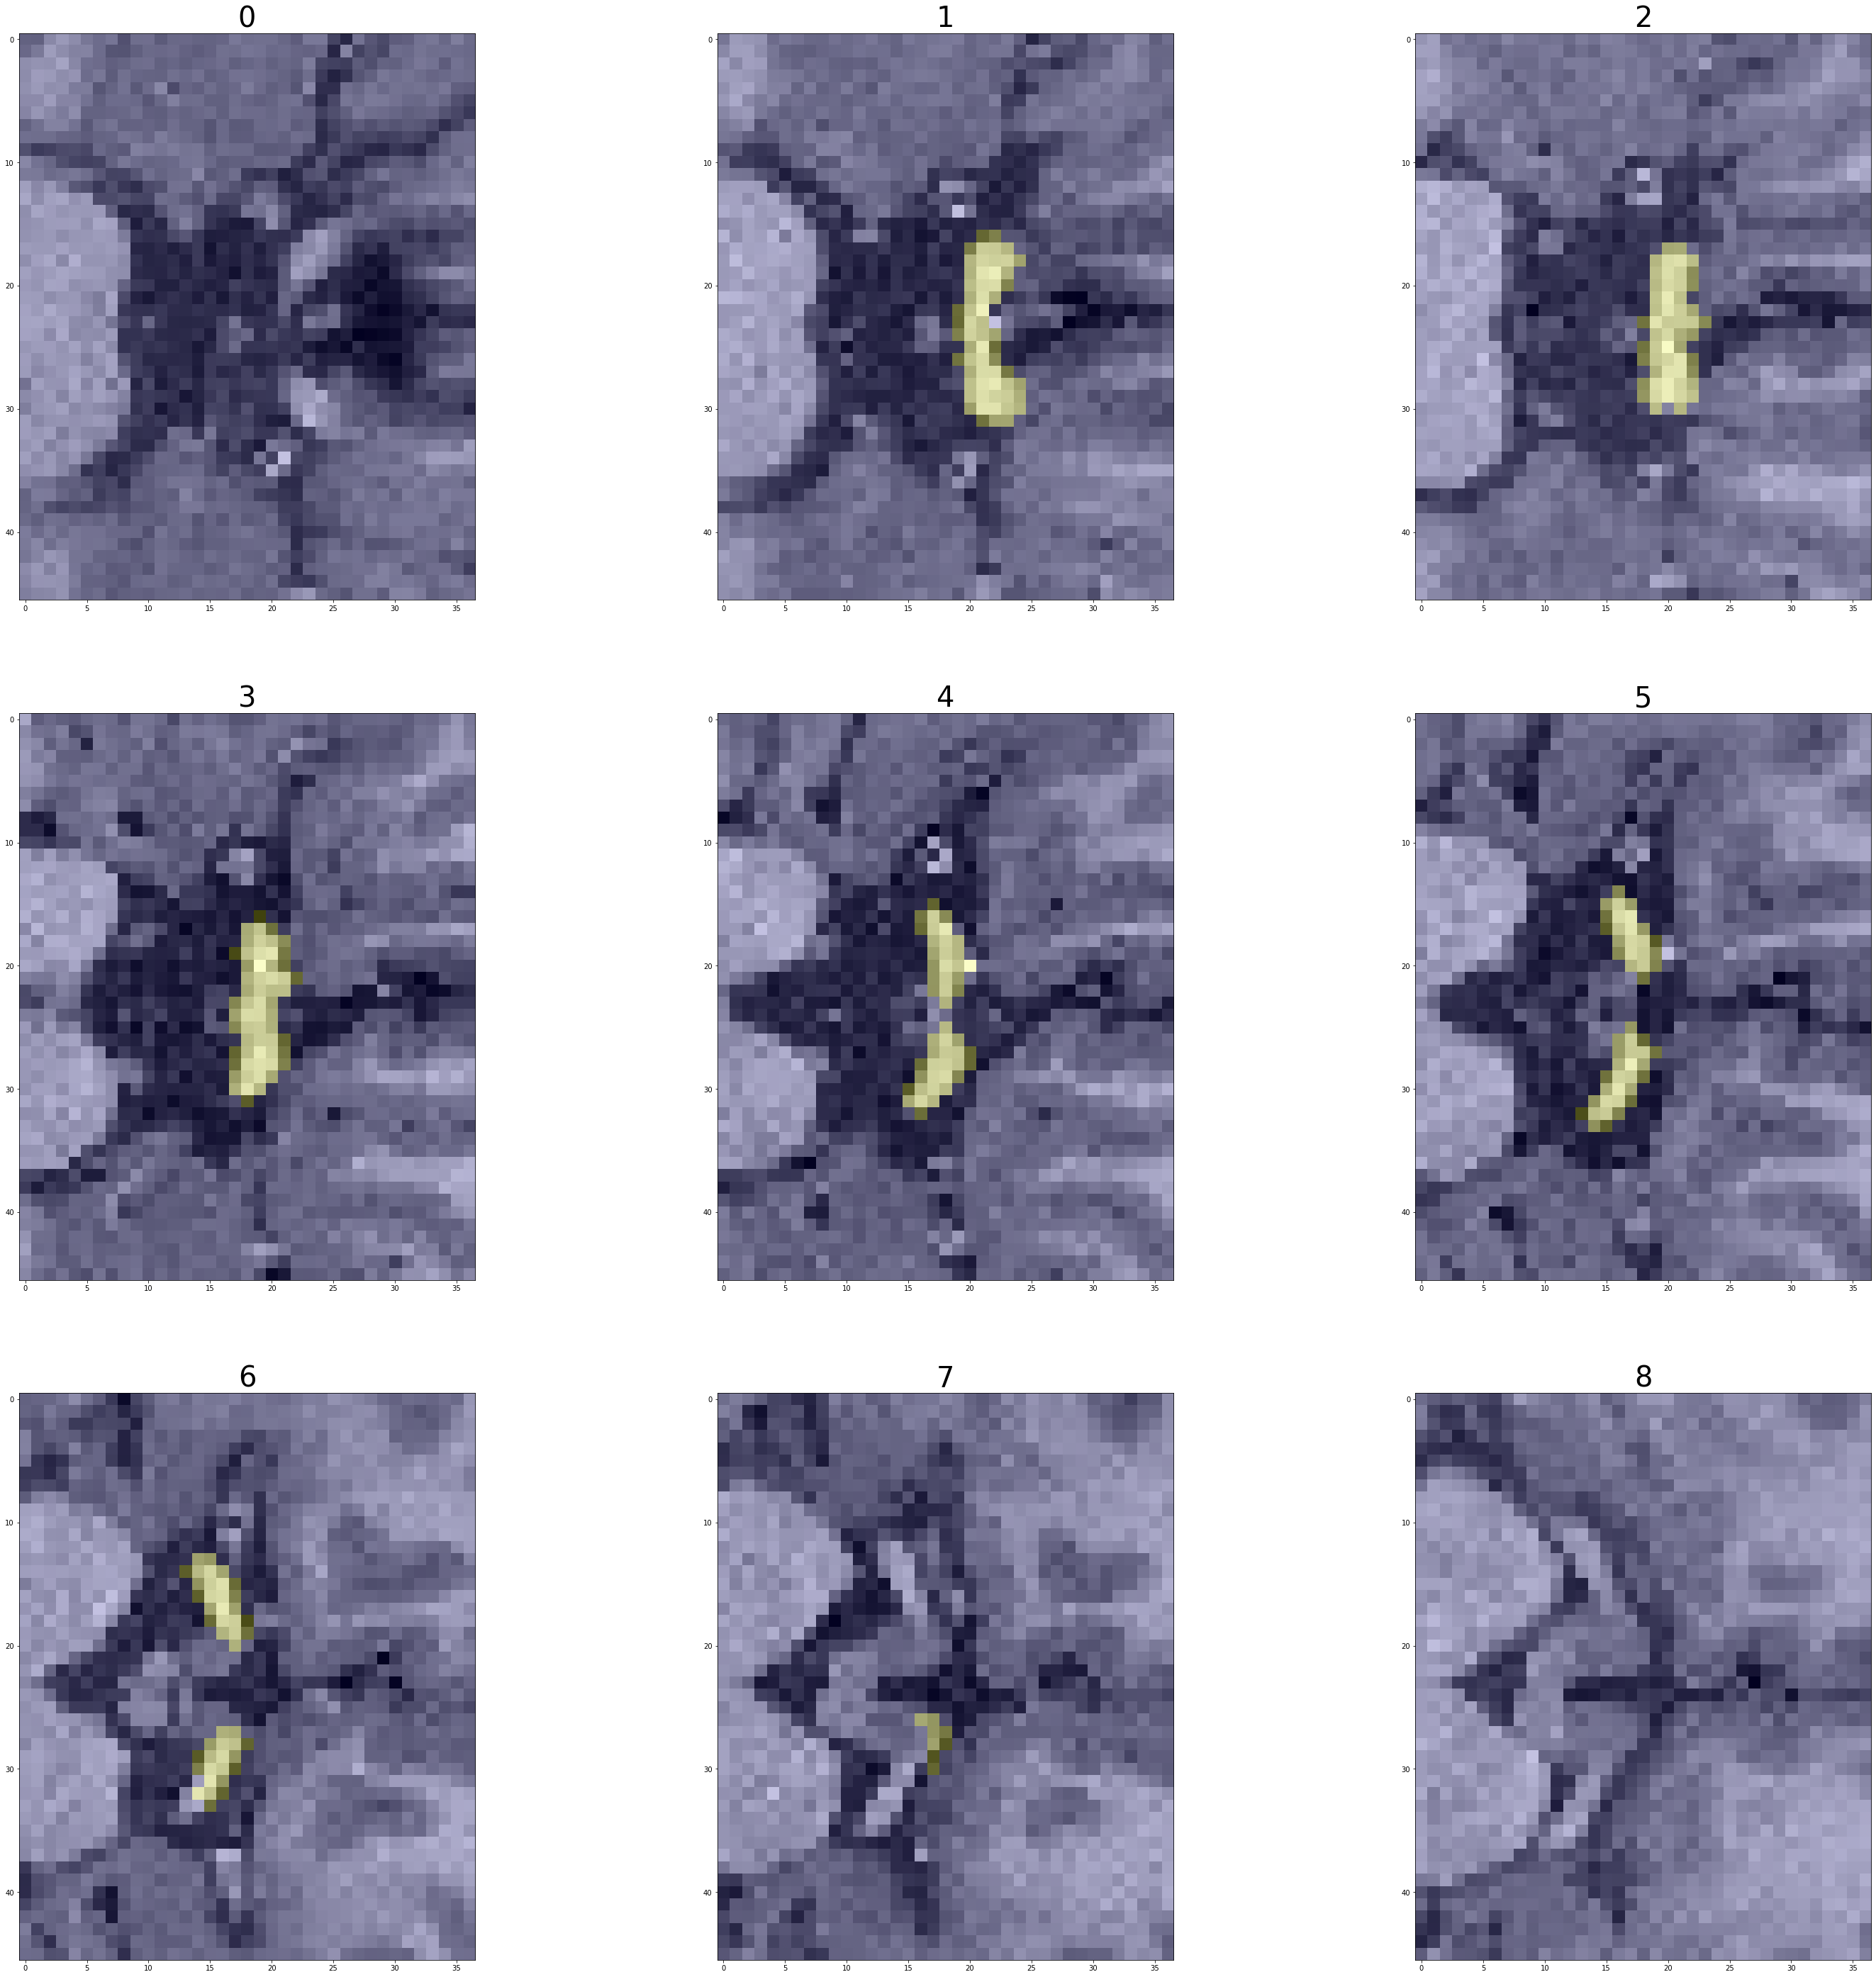

In [21]:
view_compare(t1w_data,ocmask_resampled_data,c_min-1,9, *(a_min-10,a_max+10,b_min-10,b_max+10),False, True)

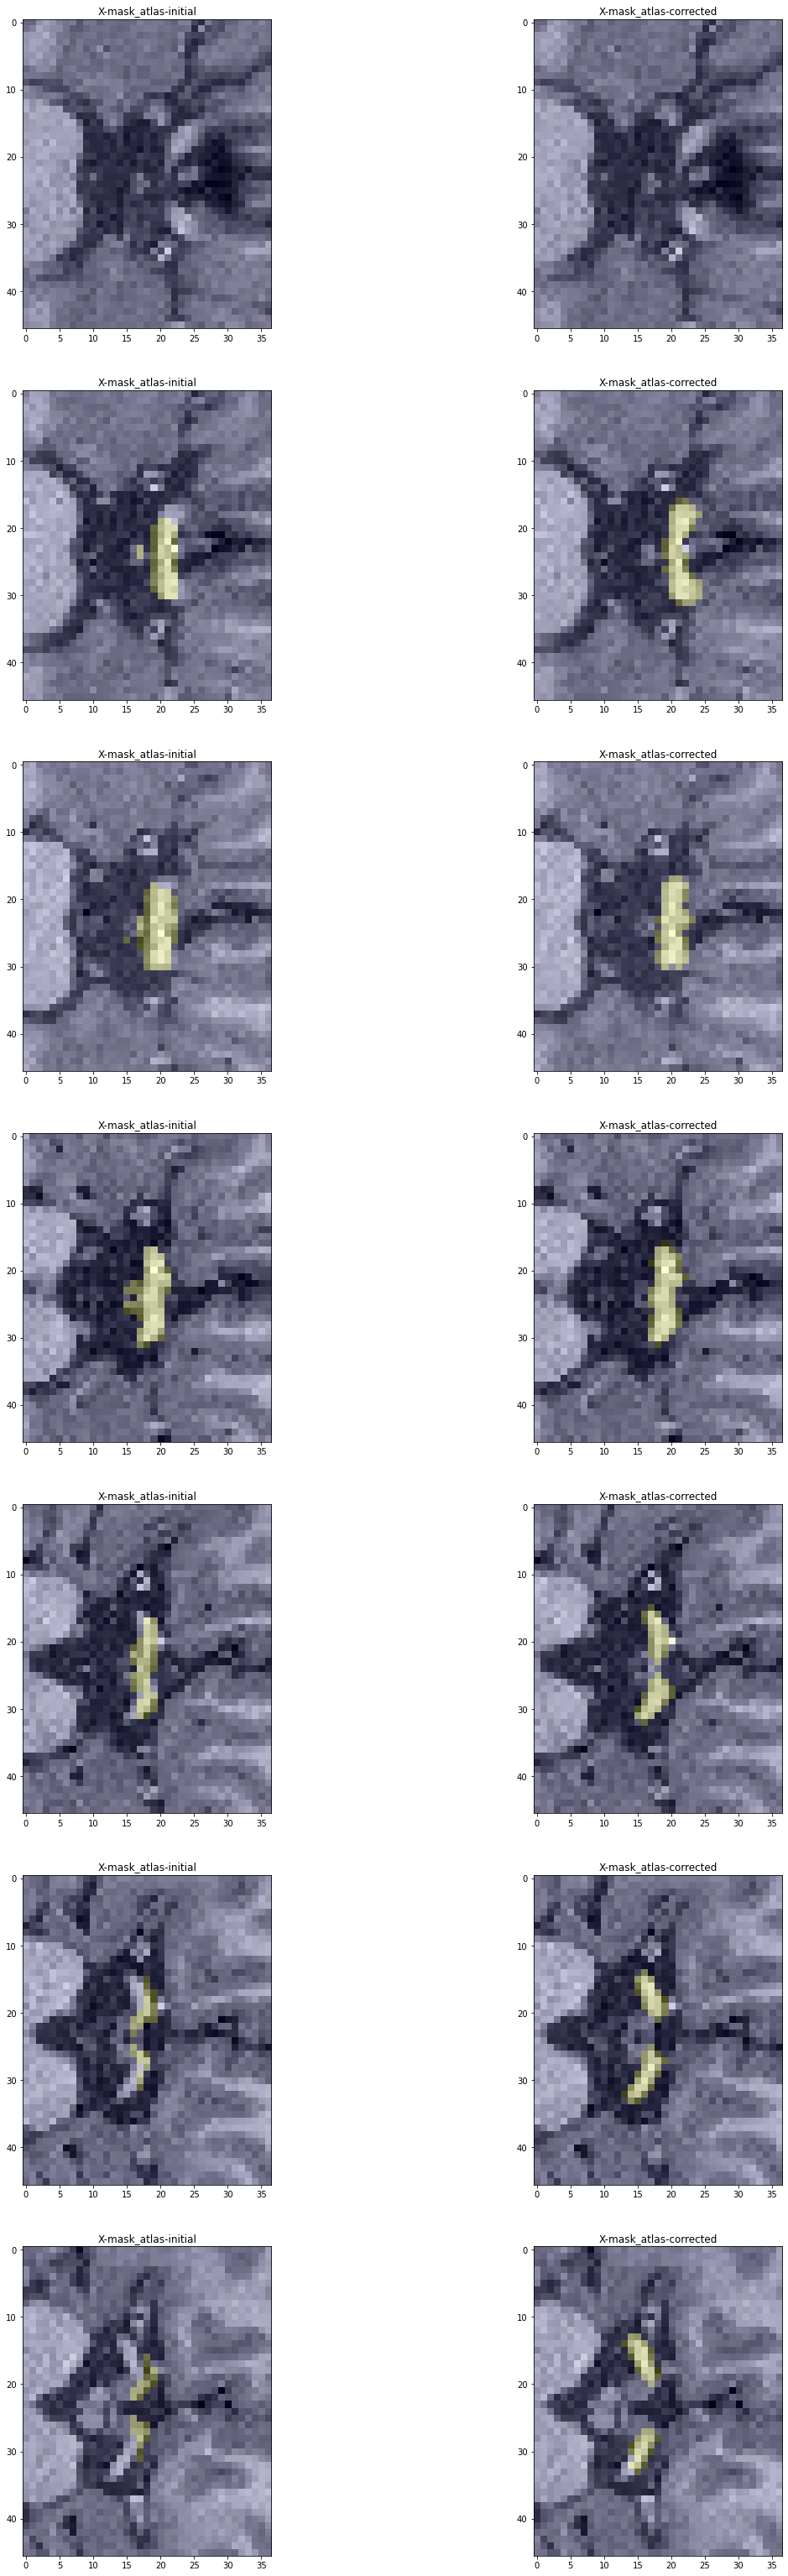

In [22]:
fig = plt.figure(figsize=(20,80))

for i in range(7):
    fig.add_subplot(10,2,2*i+1)
    plt.imshow(t1w_data[a_min-10:a_max+10,b_min-10:b_max+10,c_min-1+i], cmap='gray')
    plt.title('X-mask_atlas-initial')
    plt.imshow(old_ocmask_resampled_data[a_min-10:a_max+10,b_min-10:b_max+10,c_min-1+i]>0.1, cmap='plasma', alpha=0.2)  
    fig.add_subplot(10,2,2*i+2)
    plt.title('X-mask_atlas-corrected')
    plt.imshow(t1w_data[a_min-10:a_max+10,b_min-10:b_max+10,c_min-1+i], cmap='gray')
    plt.imshow(ocmask_resampled_data[a_min-10:a_max+10,b_min-10:b_max+10,c_min-1+i]>0.1, cmap='plasma', alpha=0.2)  